In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
savedir = '/das/work/p20/p20537/Claudio/PNG/'
os.makedirs(savedir, exist_ok=True)
print (savedir)

/das/work/p20/p20537/Claudio/PNG/


## First load a few images to identify ROIs and check threshold

In [3]:
pgroup='p20537'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [4]:
nshots = 500
threshold_low = 5
threshold_high = 50

######################################################################

total_image_on, total_image_thr_on, total_for_hist_on, total_for_hist_thr_on,\
total_image_off, total_image_thr_off, total_for_hist_off, total_for_hist_thr_off = \
XES_pp_full(fc.selected, pgroup, threshold_low, threshold_high, nshots)

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V03/gains.h5
Auto-located pedestal file: /sf/alvra/data/p20537/raw/JF_pedestals/20220909_150745.JF02T09V03.res.h5
jungfrau file: 21:36 09.09.2022
pedestal file: 15:15 09.09.2022
    mtime difference: 6:21:10.237578
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V03/gains.h5
Auto-located pedestal file: /sf/alvra/data/p20537/raw/JF_pedestals/20220909_150745.JF02T09V03.res.h5
jungfrau file: 21:36 09.09.2022
pedestal file: 15:15 09.09.2022
    mtime difference: 6:21:10.237578

--------------------------------------------------------------------------------

JF02T09V03              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Loaded 250 images ON, 250 images OFF
Now summing up 250 images ON&OFF...
It t

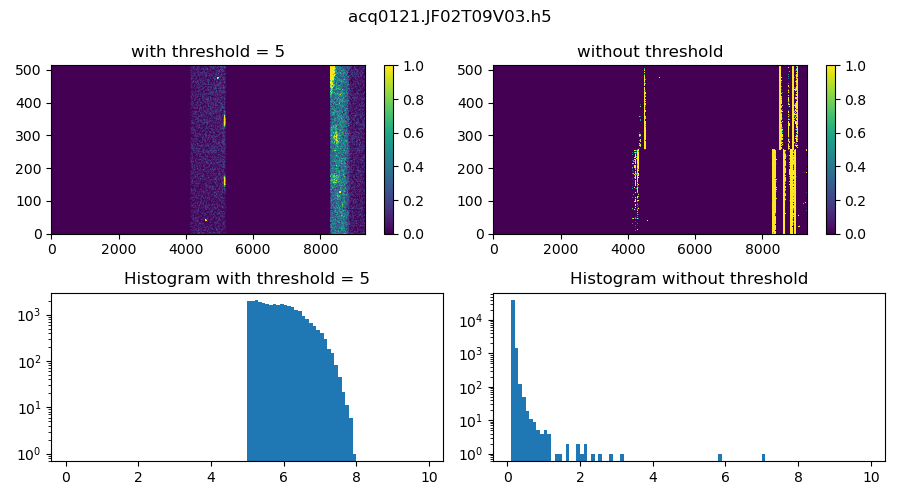

In [5]:
total_image = total_image_on + total_image_off
total_image_thr = total_image_thr_on + total_image_thr_off
total_for_hist = total_for_hist_on + total_for_hist_off
total_for_hist_thr = total_image_thr_on + total_image_thr_off

plt.figure(figsize=(9,5))
plt.suptitle(fc.selected_filename)
plt.subplots_adjust(wspace=0.5)

plt.subplot(221)
plt.imshow(total_image_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()

plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_for_hist_thr.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.subplot(222)
plt.imshow(total_image, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("without threshold")
plt.colorbar()

plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total_for_hist.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.tight_layout()
plt.show()

## Check line correction on one ROI

In [6]:
roi1 = (2900, 3100, 183, 260) #signal CRY2 low
roi2 = (2950, 3100, 250, 330) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

chosen_roi = roi1

#########################################
from scipy.signal import find_peaks

cropped_roi_on = crop_roi(total_image_thr_on, chosen_roi)
cropped_roi_off = crop_roi(total_image_thr_off, chosen_roi)

cropped_roi_on_off = cropped_roi_on + cropped_roi_off

maxvalue = np.max(cropped_roi_on_off.sum(axis=0))
refpxl = np.array(find_peaks(cropped_roi_on_off.sum(axis=0), height=maxvalue/2))[0][0]

cropped_roi_on_corrected = line_rectifier(cropped_roi_on, 5, refpxl)
cropped_roi_off_corrected = line_rectifier(cropped_roi_off, 5, refpxl)

IndexError: index 0 is out of bounds for axis 0 with size 0

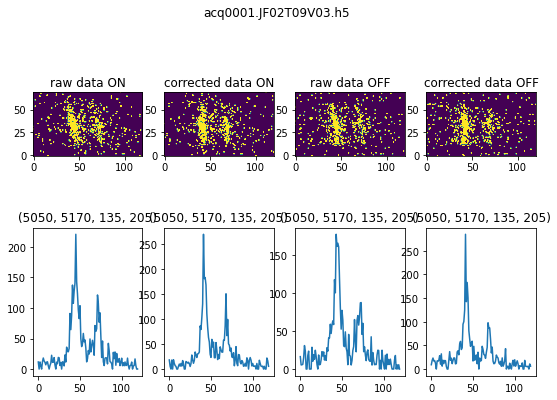

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
plt.figure(figsize=(9,6))
plt.suptitle(fc.selected_filename)

plt.subplot(241)
plt.title("raw data ON")
plt.imshow(cropped_roi_on,origin= 'lower', vmax = 1)

plt.subplot(242)
plt.title("corrected data ON")
plt.imshow(cropped_roi_on_corrected,origin= 'lower', vmax = 1)

plt.subplot(243)
plt.title("raw data OFF")
plt.imshow(cropped_roi_off,origin= 'lower', vmax = 1)

plt.subplot(244)
plt.title("corrected data OFF")
plt.imshow(cropped_roi_off_corrected,origin= 'lower', vmax = 1)

plt.subplot(245)
plt.title(chosen_roi)
plt.plot(cropped_roi_on.sum(axis=0))

plt.subplot(246)
plt.title(chosen_roi)
plt.plot(cropped_roi_on_corrected.sum(axis=0))

plt.subplot(247)
plt.title(chosen_roi)
plt.plot(cropped_roi_off.sum(axis=0))

plt.subplot(248)
plt.title(chosen_roi)
plt.plot(cropped_roi_off_corrected.sum(axis=0))
plt.show()

plt.tight_layout()

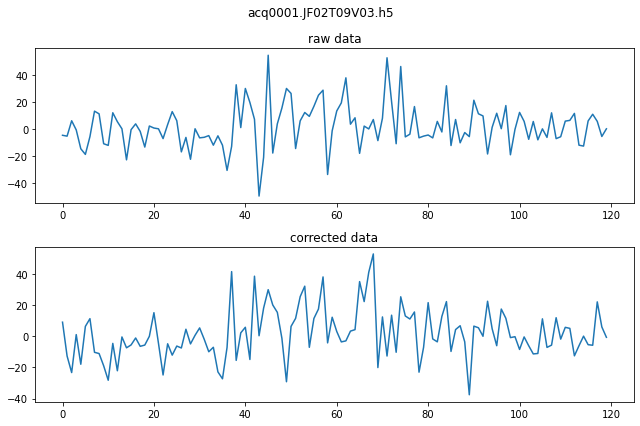

In [26]:
pp = cropped_roi_on.sum(axis=0) - cropped_roi_off.sum(axis=0)
pp_corrected = cropped_roi_on_corrected.sum(axis=0) - cropped_roi_off_corrected.sum(axis=0)

plt.figure(figsize=(9,6))
plt.suptitle(fc.selected_filename)

plt.subplot(211)
plt.title("raw data")
plt.plot(pp)

plt.subplot(212)
plt.title("corrected data")
plt.plot(pp_corrected)

plt.tight_layout()


# Single acquisition
## load file: raw/run{}/data/JF.h5

In [34]:
pgroup='p20537'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [55]:
chosenenergy = 7128

roi1 = (5050, 5200, 130, 290) #signal CRY2 low
roi2 = (5050, 5200, 310, 370) #signan CRY2 up

roi3 = (8400, 8540, 125, 225) #signal CRY1 low
roi4 = (8400, 8540, 250, 350) #signal CRY1 up

threshold_low = 5
threshold_high = 50
nshots = None
nsteps = None

correctFlag = (False,False,False,False)
binsize=5

###########################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
energy_eV = scan.readbacks

index_energy = np.arange(len(energy_eV))[(energy_eV > chosenenergy)][0]

spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
    spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
    XES_PumpProbe_4ROIs_sfdata(scan[index_energy], pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)

#print (index_energy)

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V03/gains.h5
Auto-located pedestal file: /sf/alvra/data/p20537/raw/JF_pedestals/20220909_150745.JF02T09V03.res.h5
jungfrau file: 21:14 09.09.2022
pedestal file: 15:15 09.09.2022
    mtime difference: 5:59:30.723029

--------------------------------------------------------------------------------

JF02T09V03              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 501 pump and 500 unpump shots
(5050, 5200, 130, 290) will remain as it is
(5050, 5200, 310, 370) will remain as it is
(8400, 8540, 125, 225) will remain as it is
(8400, 8540, 250, 350) will remain as it is
Loaded 501 images ON, 500 images OFF
It took 18.57 seconds to process this file


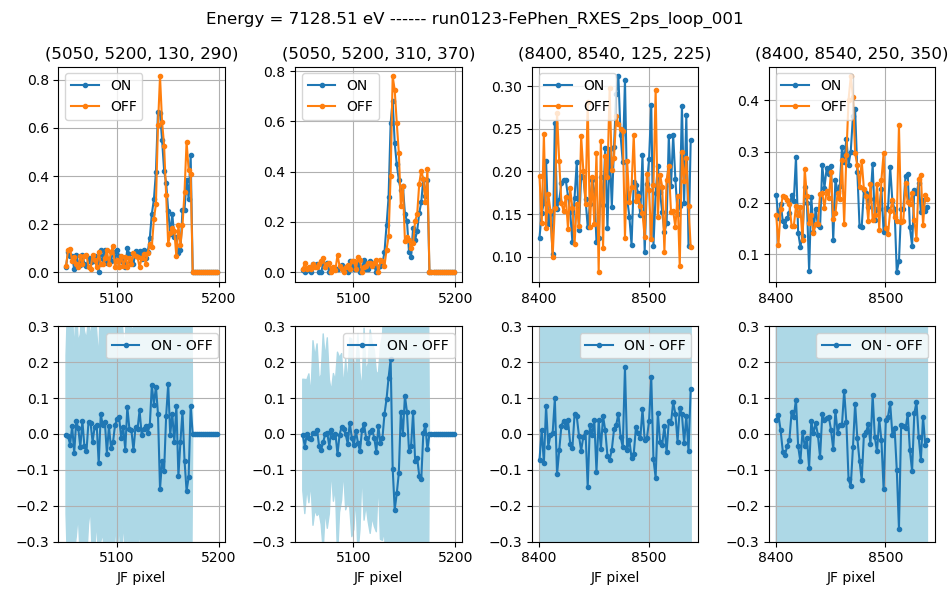

In [56]:
fig = plt.figure(figsize=(9.5, 6))
runname = fc.selected.split('/')[-3]
plt.suptitle('Energy = {:.2f} eV ------ {}'.format(energy_eV[index_energy], runname))

#plt.suptitle(runname)

binarray = [2,2,2,2] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.ylim(-0.3,0.3)
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

# Average several acquisition, same run
## load file: raw/run{}/meta/scan.json

In [65]:
pgroup='p20537'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [72]:
roi1 = (5050, 5200, 130, 290) #signal CRY2 low
roi2 = (5050, 5200, 310, 370) #signan CRY2 up

roi3 = (8400, 8540, 125, 225) #signal CRY1 low
roi4 = (8400, 8540, 250, 350) #signal CRY1 up

threshold_low = 5
threshold_high = 50120.0
nshots = None
nsteps = None

correctFlag = (False,False,False,False)
binsize=5

#####################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
runname = fc.selected.split('/')[-3]

spectrum_ON_roi1_all = []
spectrum_ON_roi2_all = []
spectrum_ON_roi3_all = []
spectrum_ON_roi4_all = []

spectrum_OFF_roi1_all = []
spectrum_OFF_roi2_all = []
spectrum_OFF_roi3_all = []
spectrum_OFF_roi4_all = []

for i, step in enumerate(scan[:nsteps]):
    clear_output(wait=True)
    print ('Processing {} out of {} files: {}'.format(i+1, len(scan), step.fnames[0].split('/')[-1].split('.')[0]))
    
    spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
    spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
    XES_PumpProbe_4ROIs_sfdata(step, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)
    
    spectrum_ON_roi1_all.append(spectrum_ON_roi1)
    spectrum_ON_roi2_all.append(spectrum_ON_roi2)
    spectrum_ON_roi3_all.append(spectrum_ON_roi3)
    spectrum_ON_roi4_all.append(spectrum_ON_roi4)
    
    spectrum_OFF_roi1_all.append(spectrum_OFF_roi1)
    spectrum_OFF_roi2_all.append(spectrum_OFF_roi2)
    spectrum_OFF_roi3_all.append(spectrum_OFF_roi3)
    spectrum_OFF_roi4_all.append(spectrum_OFF_roi4)
    

Processing 21 out of 21 files: acq0021

--------------------------------------------------------------------------------

JF02T09V03              61 / 61 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet 61 / 61 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 61 / 61 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 30 pump and 31 unpump shots
(5050, 5200, 130, 290) will remain as it is
(5050, 5200, 310, 370) will remain as it is
(8400, 8540, 125, 225) will remain as it is
(8400, 8540, 250, 350) will remain as it is
Loaded 30 images ON, 31 images OFF
It took 1.32 seconds to process this file


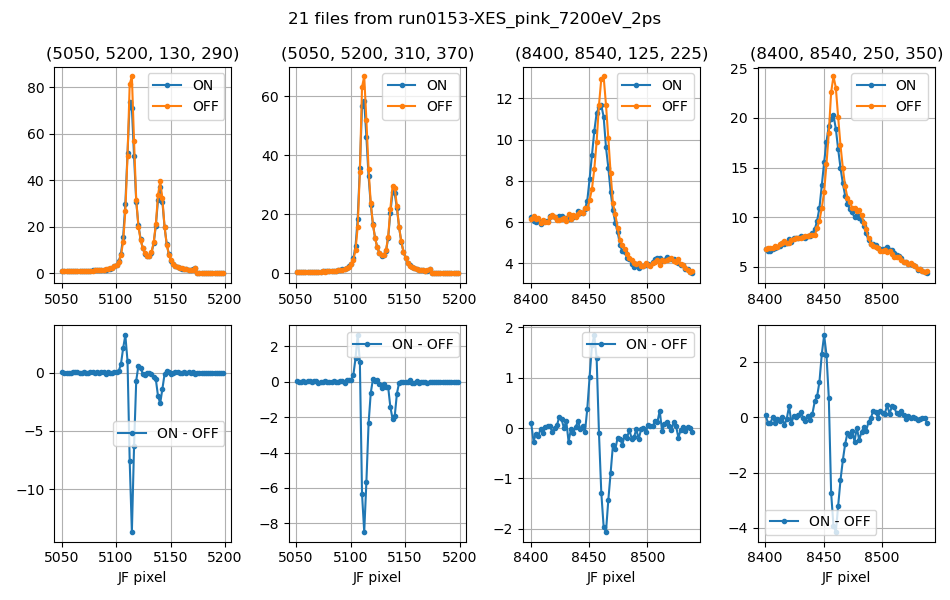

In [78]:

spectrum_ON_roi1=np.average(spectrum_ON_roi1_all, axis=0)
spectrum_ON_roi2=np.average(spectrum_ON_roi2_all, axis=0)
spectrum_ON_roi3=np.average(spectrum_ON_roi3_all, axis=0)
spectrum_ON_roi4=np.average(spectrum_ON_roi4_all, axis=0)

spectrum_OFF_roi1=np.average(spectrum_OFF_roi1_all, axis=0)
spectrum_OFF_roi2=np.average(spectrum_OFF_roi2_all, axis=0)
spectrum_OFF_roi3=np.average(spectrum_OFF_roi3_all, axis=0)
spectrum_OFF_roi4=np.average(spectrum_OFF_roi4_all, axis=0)


fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files from {}'.format(len(scan),runname))

binarray = [2,2,2,2] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    #ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    #plt.ylim(-0.5,0.5)
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

## Now with Energy calibration 

In [22]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

<IPython.core.display.Javascript object>


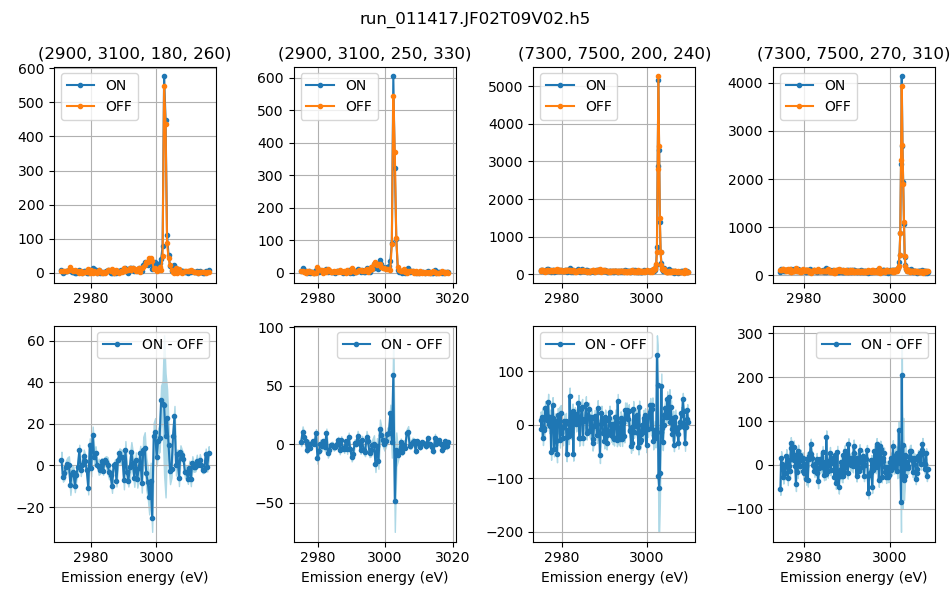

In [6]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle(fc.selected_filename)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('Emission energy (eV)')
    

plt.tight_layout()

## Next cells for a summing up identical file, ONLY JF file!

In [41]:
pgroup='p20222'

datalist = []
for file in glob(f'/sf/alvra/data/{pgroup}/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/*JF02T09V03*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist
print (len(patch))
patch

10


['/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0001.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0002.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0003.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0004.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0005.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0006.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0007.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0008.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0009.JF02T09V03.h5',
 '/sf/alvra/data/p20222/raw/run0542-FebpyCN4_EtOH_2ps_10uJ/data/acq0010.JF02T09V03.h5']

In [43]:
roi1 = (5050, 5170, 135, 205) #signal CRY2 low
roi2 = (5050, 5170, 315, 365) #signan CRY2 up

roi3 = (8400, 8540, 155, 215) #signal CRY1 low
roi4 = (8400, 8540, 295, 345) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

correctFlag = (True,True,False,False)
binsize=5

######################################################################################
from alvra_tools import clock
clock_int = clock.Clock()

spectrum_roi1_ON_all = []
spectrum_roi2_ON_all = []
spectrum_roi3_ON_all = []
spectrum_roi4_ON_all = []
spectrum_roi1_OFF_all = []
spectrum_roi2_OFF_all = []
spectrum_roi3_OFF_all = []
spectrum_roi4_OFF_all = []

for i,JF_single_file in enumerate(patch):
    
    spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
    spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
    XES_PumpProbe_4ROIs(JF_single_file, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)
    
    spectrum_roi1_ON_all.append(spectrum_ON_roi1)
    spectrum_roi2_ON_all.append(spectrum_ON_roi2)
    spectrum_roi3_ON_all.append(spectrum_ON_roi3)
    spectrum_roi4_ON_all.append(spectrum_ON_roi4)
    spectrum_roi1_OFF_all.append(spectrum_OFF_roi1)
    spectrum_roi2_OFF_all.append(spectrum_OFF_roi2)
    spectrum_roi3_OFF_all.append(spectrum_OFF_roi3)
    spectrum_roi4_OFF_all.append(spectrum_OFF_roi4)
    
    clear_output(wait=True)
    print ('{} files done out of {}'.format(i+1,len(patch)))
    print ("It took", clock_int.tick(), "seconds to process this file")

spectrum_roi1_ON_all = np.asarray(spectrum_roi1_ON_all)
spectrum_roi2_ON_all = np.asarray(spectrum_roi2_ON_all)
spectrum_roi3_ON_all = np.asarray(spectrum_roi3_ON_all)
spectrum_roi4_ON_all = np.asarray(spectrum_roi4_ON_all)
spectrum_roi1_OFF_all = np.asarray(spectrum_roi1_OFF_all)
spectrum_roi2_OFF_all = np.asarray(spectrum_roi2_OFF_all)
spectrum_roi3_OFF_all = np.asarray(spectrum_roi3_OFF_all)
spectrum_roi4_OFF_all = np.asarray(spectrum_roi4_OFF_all)

print ("It took {} seconds to process {} files".format(clock_int.tock(), len(patch)))

Processing file acq0001.JF02T09V03.h5
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V03/gains.h5
Auto-located pedestal file: /sf/alvra/data/p20222/raw/JF_pedestals/20220617_094633.JF02T09V03.res.h5
jungfrau file: 14:40 18.06.2022
pedestal file: 09:53 17.06.2022
    mtime difference: 1 day, 4:46:50.662407
Total images = 1001, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 1001, None)
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V03/gains.h5
Auto-located pedestal file: /sf/alvra/data/p20222/raw/JF_pedestals/20220617_094633.JF02T09V03.res.h5
jungfrau file: 14:40 18.06.2022
pedestal file: 09:53 17.06.2022
    mtime difference: 1 day, 4:46:50.662407

--------------------------------------------------------------------------------

JF02T09V03              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet  924 / 1001 -> 8% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 924 / 1001 -> 8% loss
complete channels: 1 / 2 -> 50%

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1001 but corresponding boolean dimension is 924

<IPython.core.display.Javascript object>


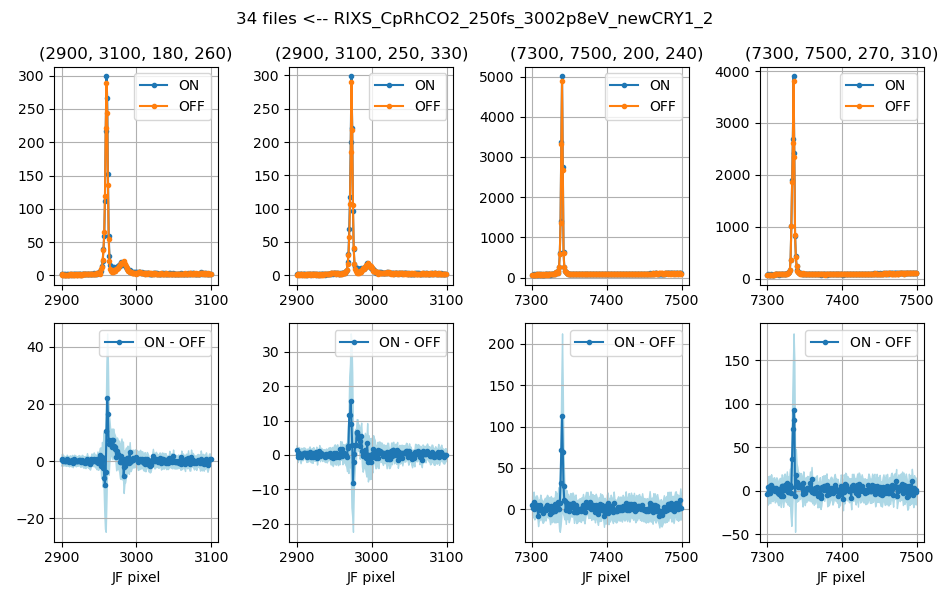

In [12]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_ON_roi1 = np.mean(spectrum_roi1_ON_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_roi2_ON_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_roi3_ON_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_roi4_ON_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_roi1_OFF_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_roi2_OFF_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_roi3_OFF_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_roi4_OFF_all, axis = 0)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

## Now with Energy calibration 

In [7]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

<IPython.core.display.Javascript object>


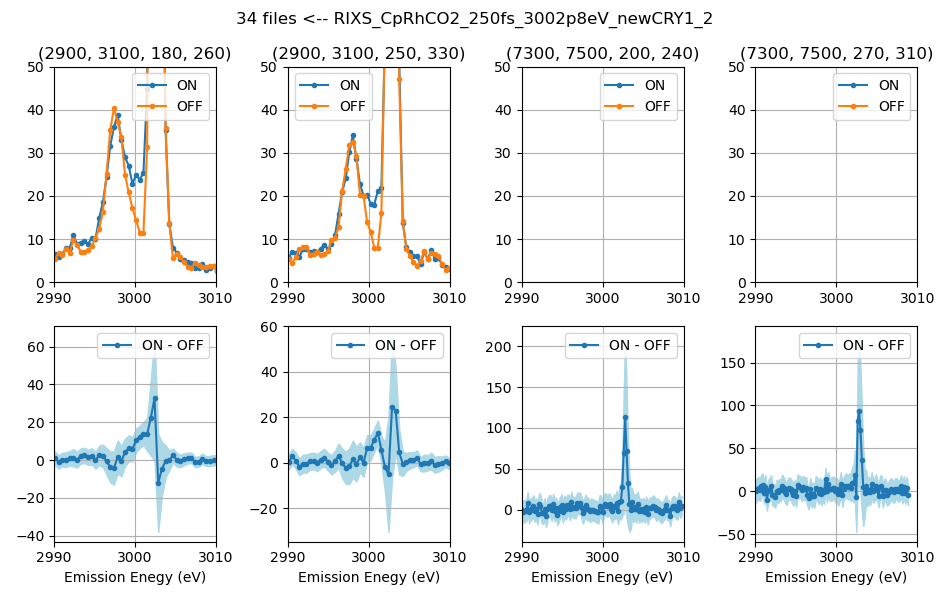

In [13]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_ON_roi1 = np.mean(spectrum_roi1_ON_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_roi2_ON_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_roi3_ON_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_roi4_ON_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_roi1_OFF_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_roi2_OFF_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_roi3_OFF_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_roi4_OFF_all, axis = 0)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.ylim(0,50)
    plt.xlim(2990,3010)
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.xlim(2990,3010)
    plt.grid()
    plt.xlabel('Emission Enegy (eV)')
    
plt.tight_layout()

#plt.savefig(savedir + patch[0].split('/')[-2] + '_corrected.png')

In [ ]:
outdir = '/das/work/p18/p18442/Exported_data/'
filename_h5 = outdir + scan_name + "_export.h5" 
with h5py.File(filename_h5, "w") as file2write:
    file2write.create_dataset("energy_eV", data = Energy_eV)
    file2write.create_dataset("roi1", data = roi1)
    file2write.create_dataset("pump_roi1", data = RIXS_pumped_roi1)
    file2write.create_dataset("unpump_roi1", data = RIXS_unpumped_roi1)
    file2write.create_dataset("transient_roi1", data = RIXS_transient_roi1)
    file2write.create_dataset("roi2", data = roi2)
    file2write.create_dataset("pump_roi2", data = RIXS_pumped_roi2)
    file2write.create_dataset("unpump_roi2", data = RIXS_unpumped_roi2)
    file2write.create_dataset("transient_roi2", data = RIXS_transient_roi2)

print(filename_h5)

In [ ]:
scan_name_load = 'RuBpy_RIXS_6'

##########################################################

outdir = '/das/work/p18/p18442/Exported_data/'
fn = outdir + scan_name_load + "_export.h5" 
print (fn)
with h5py.File(fn, "r") as file2open:
    Energy_eV = file2open['energy_eV'][:]
    roi1 = file2open['roi1'][:]
    RIXS_pumped_roi1 = file2open['pump_roi1'][:]
    RIXS_unpumped_roi1 = file2open['unpump_roi1'][:]
    RIXS_transient_roi1 = file2open['transient_roi1'][:]
    roi2 = file2open['roi2'][:]
    RIXS_pumped_roi2 = file2open['pump_roi2'][:]
    RIXS_unpumped_roi2 = file2open['unpump_roi2'][:]
    RIXS_transient_roi2 = file2open['transient_roi2'][:]

<IPython.core.display.Javascript object>


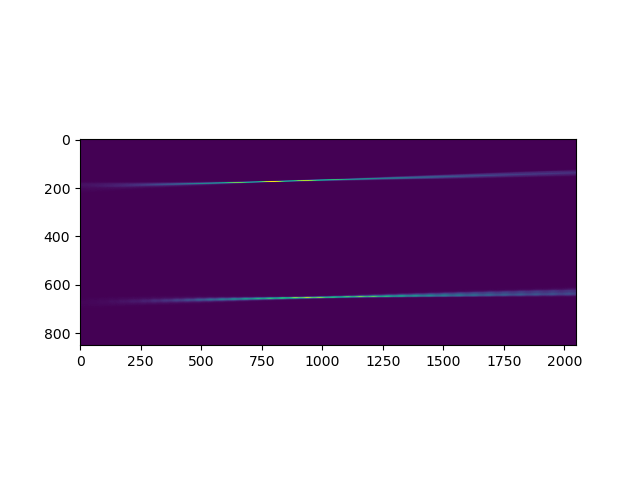

In [7]:
with SFDataFiles("/sf/alvra/data/p18938/raw/scan_data/SiN_timing_NOPA_shortX_loop3_000/run_014886.CAMERAS.h5") as sfd:
    ch = sfd['SARES11-SPEC125-M2:FPICTURE']
    img = ch.data[0]

plt.imshow(img)